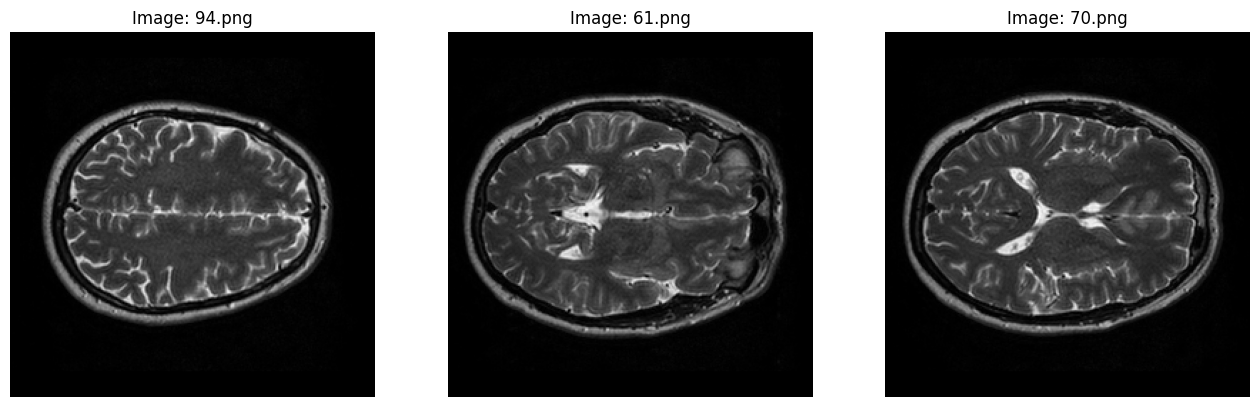

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm

data_directory = '/kaggle/input/ixit2-slices/image slice-T2'

if not os.path.exists(data_directory):
    raise FileNotFoundError("Dataset not found. Ensure this script is running in a Kaggle environment with access to the specified dataset.")

subject_list = os.listdir(data_directory)

selected_subject_path = os.path.join(data_directory, subject_list[0])

slice_files = os.listdir(selected_subject_path)

figure, subplot_axes = plt.subplots(1, 3, figsize=(16, 8))

for index, slice_name in enumerate(slice_files[:3]):
    slice_path = os.path.join(selected_subject_path, slice_name)
    slice_image = Image.open(slice_path)
    subplot_axes[index].imshow(slice_image, cmap='gray')
    subplot_axes[index].set_title(f'Image: {slice_name}')
    subplot_axes[index].axis('off')

plt.show()


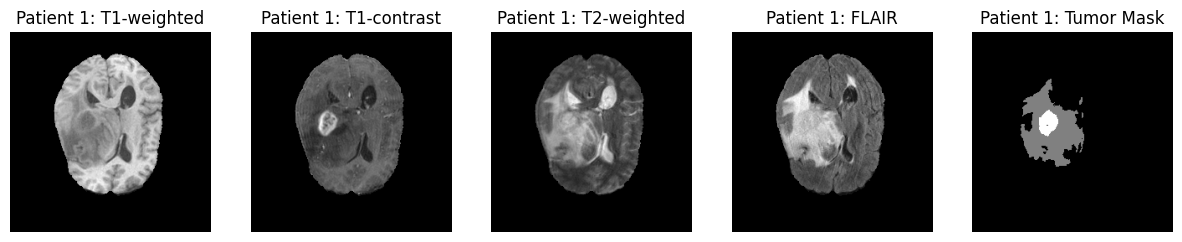

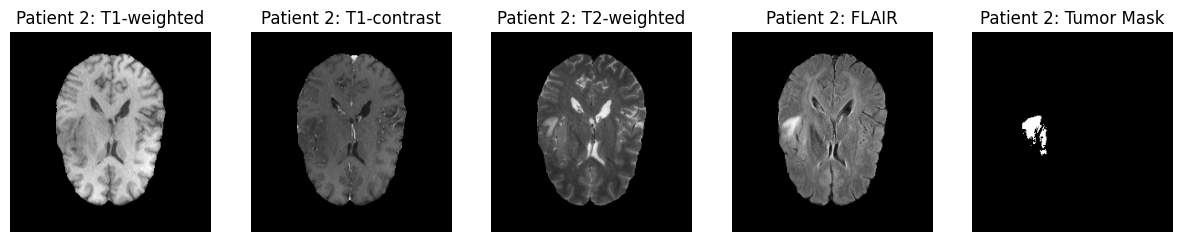

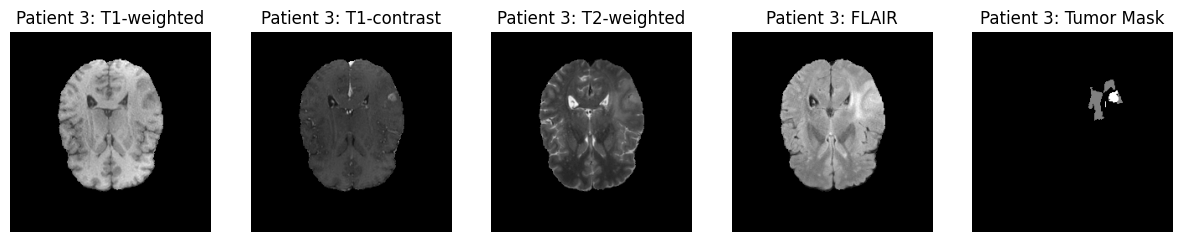

In [2]:
data_path = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

patient_indices = [1, 2, 3]

for patient_index in patient_indices:
    patient_folder = f'BraTS20_Training_00{patient_index}'
    patient_path = os.path.join(data_path, patient_folder)

    scan_types = {
        'T1-weighted': '_t1.nii',
        'T1-contrast': '_t1ce.nii',
        'T2-weighted': '_t2.nii',
        'FLAIR': '_flair.nii',
        'Tumor Mask': '_seg.nii'
    }

    plot_fig, axes_grid = plt.subplots(1, len(scan_types), figsize=(15, 5))

    for idx, (scan_label, file_suffix) in enumerate(scan_types.items()):
        file_location = os.path.join(patient_path, f'{patient_folder}{file_suffix}')
        nifti_image = nib.load(file_location)
        image_array = nifti_image.get_fdata()
        central_slice = image_array[:, :, image_array.shape[2] // 2]
        
        axes_grid[idx].imshow(central_slice.T, cmap='gray', origin='lower')
        axes_grid[idx].set_title(f'Patient {patient_index}: {scan_label}')
        axes_grid[idx].axis('off')

    plt.show()


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class ImageDataset(Dataset):
    def __init__(self, dataset_dir, img_transform=None):
        self.dataset_dir = dataset_dir
        self.img_transform = img_transform
        self.image_files = [os.path.join(dirpath, file) 
                            for dirpath, _, filenames in os.walk(dataset_dir) 
                            for file in filenames if file.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_path = self.image_files[index]
        img = Image.open(image_path).convert('L')
        if self.img_transform:
            img = self.img_transform(img)
        return img

In [5]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_size):
        super(VariationalAutoencoder, self).__init__()
        self.latent_size = latent_size
        self.encoder_net = self.build_encoder()
        self.mean_layer = nn.Linear(128 * 32 * 32, latent_size)
        self.logvar_layer = nn.Linear(128 * 32 * 32, latent_size)
        self.decoder_net = self.build_decoder()

    def build_encoder(self):
        return nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

    def build_decoder(self):
        return nn.Sequential(
            nn.Unflatten(1, (128, 32, 32)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mean, logvar):
        std_dev = torch.exp(0.5 * logvar)
        noise = torch.randn_like(std_dev)
        return mean + noise * std_dev

    def forward(self, x):
        encoded = self.encoder_net(x)
        mean = self.mean_layer(encoded)
        logvar = self.logvar_layer(encoded)
        z = self.reparameterize(mean, logvar)
        decoded = self.decoder_net(self.decode_latent(z))
        return decoded, mean, logvar

    def decode_latent(self, z):
        return self.mean_layer.weight.T.matmul(z.T).T


In [6]:
def preprocess_nifti_slice(slice_data, target_size):
    normalized_data = slice_data / np.max(slice_data)
    resized_image = Image.fromarray((normalized_data * 255).astype(np.uint8)).resize(target_size)
    return torch.tensor(np.array(resized_image) / 255.0, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

In [7]:
def detect_tumor_with_model(model, input_tensor, threshold=0.1):
    model.eval()
    with torch.no_grad():
        reconstructed, _, _ = model(input_tensor.to(device))
    diff_map = torch.abs(input_tensor - reconstructed).squeeze().cpu().numpy()
    tumor_pred = (diff_map > threshold).astype(np.uint8)
    return diff_map, tumor_pred

In [8]:
def visualize_tumor_detection(original, diff_map, pred_mask, true_mask, modality, patient):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    titles = ["Original Image", "Error Map", "Predicted Mask", "True Mask"]
    images = [original.T, diff_map.T, pred_mask.T, true_mask.T]
    cmaps = ['gray', 'hot', 'gray', 'gray']

    for ax, img, title, cmap in zip(axes, images, titles, cmaps):
        ax.imshow(img, cmap=cmap, origin='lower')
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [9]:
def train_and_save_model(latent_dim, dataloader, num_epochs, save_path):
    vae = VariationalAutoencoder(latent_size=latent_dim)
    optimizer = optim.Adam(vae.parameters(), lr=0.001)
    vae.to(device)
    vae.train()

    loss_history = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")
        for batch in progress_bar:
            batch = batch.to(device)
            optimizer.zero_grad()
            reconstructed, mean, logvar = vae(batch)
            loss = calculate_loss(reconstructed, batch, mean, logvar)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        average_loss = epoch_loss / len(dataloader)
        loss_history.append(average_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}: Loss: {average_loss:.4f}")

    # Plot loss history
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

    torch.save(vae.state_dict(), save_path)
    print(f"Model saved at {save_path}")
    return vae


def calculate_loss(reconstructed, original, mean, logvar):
    recon_loss = nn.MSELoss(reduction='sum')(reconstructed, original)
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [10]:
def calculate_dice_coefficient(pred, true):
    pred_flat = pred.flatten()
    true_resized = np.array(Image.fromarray(true.astype(np.uint8)).resize((256, 256), Image.NEAREST)) > 0
    true_flat = true_resized.flatten()
    intersection = np.sum(pred_flat * true_flat)
    return (2.0 * intersection) / (np.sum(pred_flat) + np.sum(true_flat))

In [11]:
def analyze_patient_slices(vae, patient_ids, dataset_path, target_size, threshold):
    for patient_idx in patient_ids:
        patient_id = f'BraTS20_Training_00{patient_idx}'
        patient_dir = os.path.join(dataset_path, patient_id)

        flair_path = os.path.join(patient_dir, f'{patient_id}_flair.nii')
        seg_path = os.path.join(patient_dir, f'{patient_id}_seg.nii')

        flair_data = nib.load(flair_path).get_fdata()
        seg_data = nib.load(seg_path).get_fdata()

        mid_slice_idx = flair_data.shape[2] // 2
        flair_slice = flair_data[:, :, mid_slice_idx]
        seg_slice = seg_data[:, :, mid_slice_idx]

        input_tensor = preprocess_nifti_slice(flair_slice, target_size).to(device)
        error_map, pred_mask = detect_tumor_with_model(vae, input_tensor, threshold)
        dice_score = calculate_dice_coefficient(pred_mask, seg_slice)

        visualize_tumor_detection(flair_slice, error_map, pred_mask, seg_slice, "FLAIR", patient_id)
        print(f"Patient: {patient_id}, Dice Score: {dice_score:.4f}")

In [12]:
def main():
    healthy_dataset_dir = '/kaggle/input/ixit2-slices/image slice-T2'
    unhealthy_dataset_dir = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

    patient_indices = [1,2,3]
    target_image_size = (256, 256)
    threshold_value = 0.3
    latent_dim = 128
    model_path = "/kaggle/working/vae_model.pth"

    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    print("Loading healthy dataset for training...")
    healthy_dataset = ImageDataset(healthy_dataset_dir, img_transform=preprocess)
    healthy_dataloader = DataLoader(healthy_dataset, batch_size=4, shuffle=True)

    vae = train_and_save_model(latent_dim, healthy_dataloader, num_epochs=20, save_path=model_path)

    print("Analyzing unhealthy dataset...")
    analyze_patient_slices(vae, patient_indices, unhealthy_dataset_dir, target_image_size, threshold_value)


Loading healthy dataset for training...


Epoch 1/20: 100%|██████████| 7213/7213 [05:21<00:00, 22.44batch/s, loss=972]    


Epoch 1/20: Loss: 2599.2528


Epoch 2/20: 100%|██████████| 7213/7213 [03:14<00:00, 37.02batch/s, loss=992]    


Epoch 2/20: Loss: 1956.6959


Epoch 3/20: 100%|██████████| 7213/7213 [03:04<00:00, 39.09batch/s, loss=586]    


Epoch 3/20: Loss: 1793.9915


Epoch 4/20: 100%|██████████| 7213/7213 [03:02<00:00, 39.60batch/s, loss=882]    


Epoch 4/20: Loss: 1713.8360


Epoch 5/20: 100%|██████████| 7213/7213 [03:00<00:00, 39.85batch/s, loss=715]    


Epoch 5/20: Loss: 1661.3062


Epoch 6/20: 100%|██████████| 7213/7213 [03:02<00:00, 39.57batch/s, loss=833]    


Epoch 6/20: Loss: 1623.6369


Epoch 7/20: 100%|██████████| 7213/7213 [03:01<00:00, 39.75batch/s, loss=679]    


Epoch 7/20: Loss: 1593.9945


Epoch 8/20: 100%|██████████| 7213/7213 [03:00<00:00, 39.94batch/s, loss=628]    


Epoch 8/20: Loss: 1569.0214


Epoch 9/20: 100%|██████████| 7213/7213 [03:01<00:00, 39.75batch/s, loss=916]    


Epoch 9/20: Loss: 1547.4416


Epoch 10/20: 100%|██████████| 7213/7213 [03:03<00:00, 39.34batch/s, loss=721]    


Epoch 10/20: Loss: 1529.4708


Epoch 11/20: 100%|██████████| 7213/7213 [03:03<00:00, 39.31batch/s, loss=801]    


Epoch 11/20: Loss: 1514.0792


Epoch 12/20: 100%|██████████| 7213/7213 [03:03<00:00, 39.37batch/s, loss=788]    


Epoch 12/20: Loss: 1499.7213


Epoch 13/20: 100%|██████████| 7213/7213 [03:04<00:00, 39.13batch/s, loss=763]    


Epoch 13/20: Loss: 1486.2596


Epoch 14/20: 100%|██████████| 7213/7213 [03:02<00:00, 39.62batch/s, loss=588]    


Epoch 14/20: Loss: 1475.5904


Epoch 15/20: 100%|██████████| 7213/7213 [03:02<00:00, 39.42batch/s, loss=729]    


Epoch 15/20: Loss: 1464.7148


Epoch 16/20: 100%|██████████| 7213/7213 [03:02<00:00, 39.49batch/s, loss=709]    


Epoch 16/20: Loss: 1454.6918


Epoch 17/20: 100%|██████████| 7213/7213 [03:02<00:00, 39.44batch/s, loss=610]    


Epoch 17/20: Loss: 1446.5362


Epoch 18/20: 100%|██████████| 7213/7213 [03:01<00:00, 39.73batch/s, loss=861]    


Epoch 18/20: Loss: 1437.8201


Epoch 19/20: 100%|██████████| 7213/7213 [03:00<00:00, 39.97batch/s, loss=713]    


Epoch 19/20: Loss: 1430.7217


Epoch 20/20: 100%|██████████| 7213/7213 [03:01<00:00, 39.79batch/s, loss=844]    


Epoch 20/20: Loss: 1424.5250


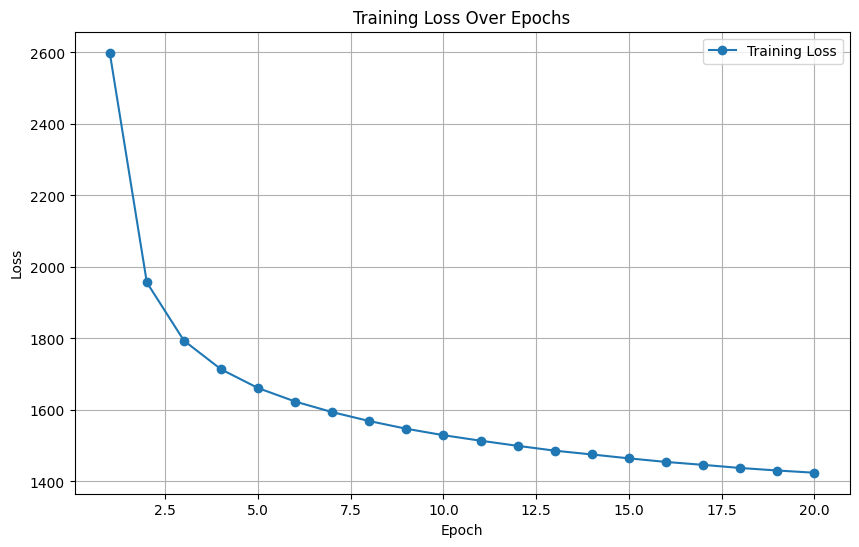

Model saved at /kaggle/working/vae_model.pth
Analyzing unhealthy dataset...


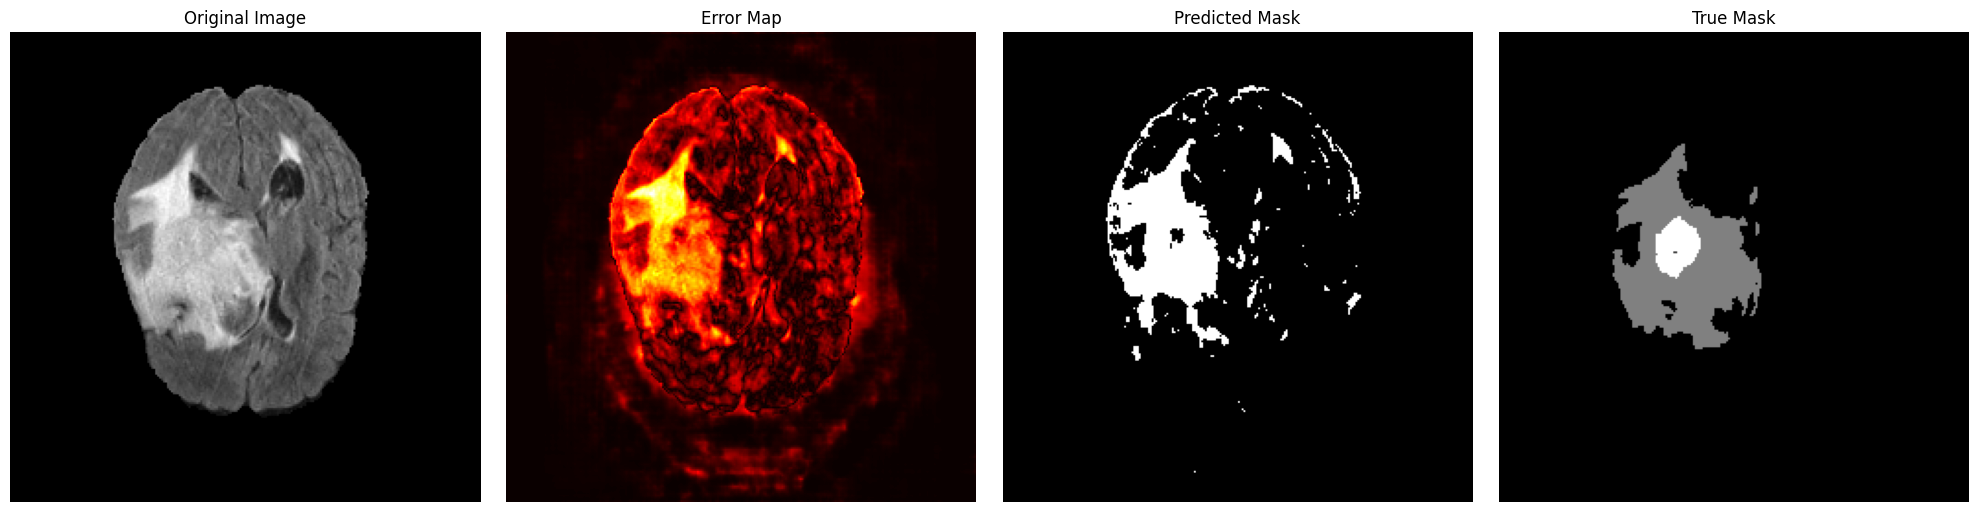

Patient: BraTS20_Training_001, Dice Score: 0.6929


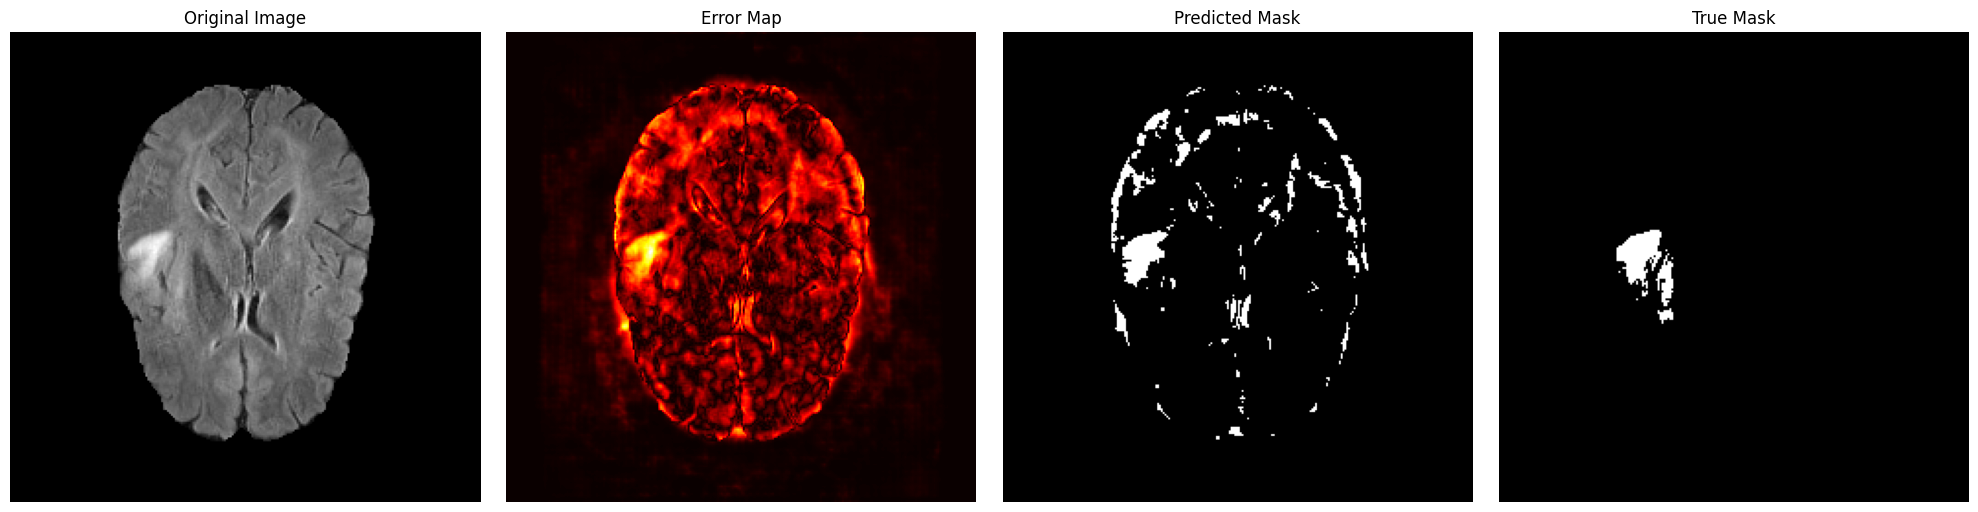

Patient: BraTS20_Training_002, Dice Score: 0.3078


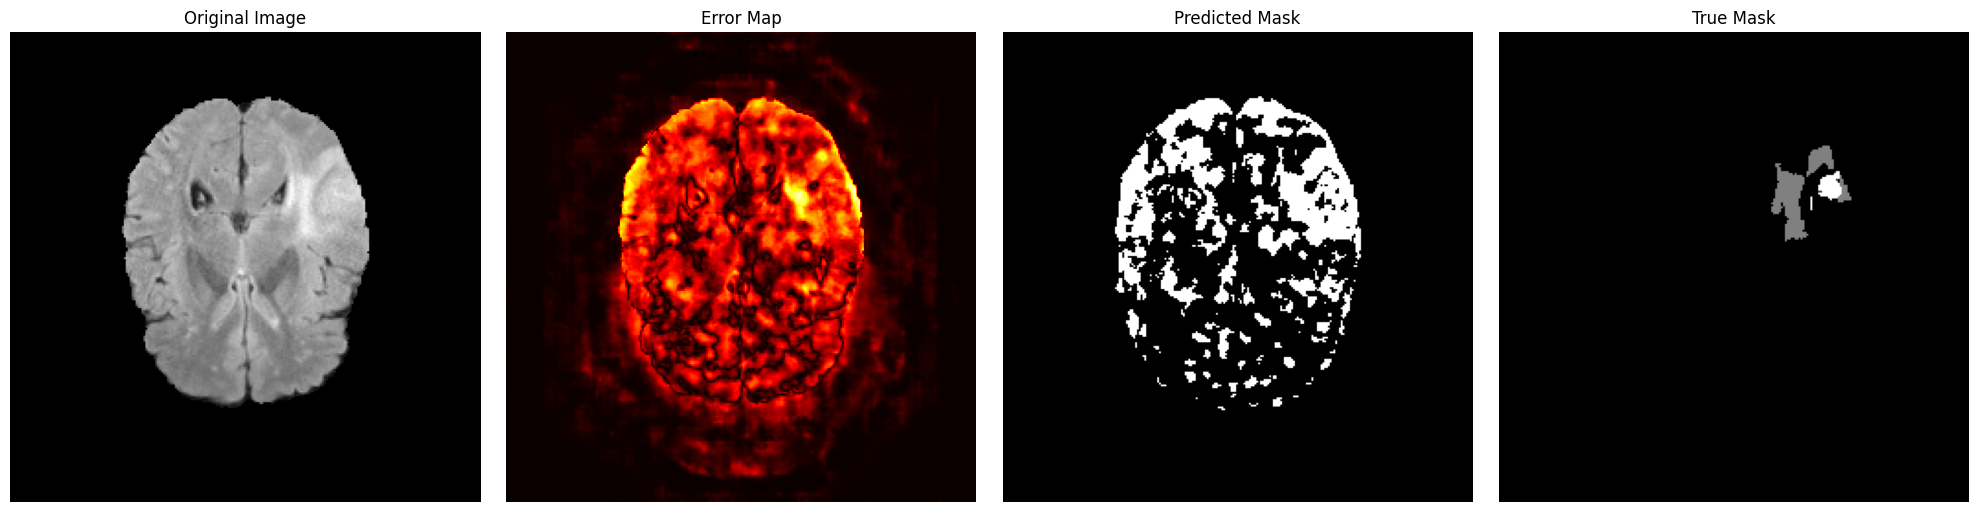

Patient: BraTS20_Training_003, Dice Score: 0.1920


In [13]:
if __name__ == "__main__":
    main()